In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# the generator will crop all images into this shape
image_shape = (224, 224)
# this means images are in RGB mode
channel = 3
full_image_shape = image_shape + (channel, )
batch_size = 32
num_classes = 150

In [3]:
datagen = ImageDataGenerator(
    # makes all value in range between 0 and 1
    rescale=1. / 255,
    # we'll finally get 5511 images for training and 1309 for validation
    validation_split=0.2
)

# flow_from_directory reads only one batch of data each step, 
# this is helpful when dataset is too huge to be completely stored in memory
train_generator = datagen.flow_from_directory(
    directory='PokemonData',
    target_size=image_shape, 
    batch_size=batch_size, 
    subset='training'
)

val_generator = datagen.flow_from_directory(
    directory='PokemonData',
    target_size=image_shape, 
    batch_size=batch_size, 
    subset='validation'
)

Found 5511 images belonging to 150 classes.
Found 1309 images belonging to 150 classes.


In [4]:
# the number of batches which is also the steps per epoch
num_train = len(train_generator)
num_val = len(val_generator)

In [5]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [6]:
base_model = MobileNetV2(
    input_shape=full_image_shape, 
    alpha=1.0, 
    include_top=False, 
    # this is the pretrained weights used in images processing
    weights='imagenet', 
    input_tensor=Input(full_image_shape), 
    pooling=None, 
    classes=num_classes
)

In [7]:
# snag the last layer of the imported model
x = base_model.layers[-1].output

x = GlobalMaxPooling2D()(x)
x = Dense(1024,activation='relu')(x)
x = Dense(num_classes, activation='softmax', name='predictions')(x)

# we can define the last few layers by ourselves
model = Model(inputs=base_model.input, outputs=x)

# let's train all the layers
for layer in model.layers:
    layer.training = True

In [8]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

In [9]:
# these are utilities to maximize learning, while preventing over-fitting
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    patience=12, 
    cooldown=6, 
    rate=0.6,  
    min_lr=1e8, 
    verbose=1
)
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=24, 
    verbose=1
)

# this save the best model which has the minimal validation loss
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='val_loss', 
    mode='min', 
    save_best_only=True)

In [10]:
# compile and train the network
model.compile(
    optimizer=Adam(1e-4), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

In [11]:
# train the model for 200 epochs
history = model.fit_generator(
    train_generator, 
    validation_data=val_generator, 
    steps_per_epoch=num_train, 
    validation_steps=num_val, 
    epochs=200, 
    shuffle=True, 
    callbacks=[reduce_lr, early_stop, checkpoint]
)

Epoch 1/200
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
173/173 [==============================] - 155s 893ms/step - loss: 4.8642 - accuracy: 0.1303 - val_loss: 3.6100 - val_accuracy: 0.2376
Epoch 2/200
173/173 [==============================] - 92s 532ms/step - loss: 1.3555 - accuracy: 0.6739 - val_loss: 2.2955 - val_accuracy: 0.4469
Epoch 3/200
173/173 [==============================] - 92s 531ms/step - loss: 0.3731 - accuracy: 0.9109 - val_loss: 1.5594 - val_accuracy: 0.6203
Epoch 4/200
173/173 [==============================] - 93s 535ms/step - loss: 0.1343 - accuracy: 0.9721 - val_loss: 1.2274 - val_accuracy: 0.6929
Epoch 5/200
173/173 [==============================] - 92s 532ms/step - loss: 0.0561 - accuracy: 0.9922 - val_loss: 1.0860 - val_accuracy: 0.7357
Epoch 6/200
173/173 [==============================] - 92s 530ms/step - loss: 0.0468 - accuracy: 0.9940 - val_loss: 1.0232 - val_accuracy: 0.7441
Epoch 7/200
173/173 [========

173/173 [==============================] - 90s 522ms/step - loss: 0.0113 - accuracy: 0.9975 - val_loss: 0.5729 - val_accuracy: 0.8869
Epoch 55/200
173/173 [==============================] - 91s 524ms/step - loss: 0.0122 - accuracy: 0.9976 - val_loss: 0.4937 - val_accuracy: 0.8992
Epoch 56/200
173/173 [==============================] - 90s 521ms/step - loss: 0.0086 - accuracy: 0.9980 - val_loss: 0.5186 - val_accuracy: 0.8992
Epoch 57/200
173/173 [==============================] - 90s 518ms/step - loss: 0.0147 - accuracy: 0.9969 - val_loss: 0.5703 - val_accuracy: 0.8930
Epoch 58/200
173/173 [==============================] - 90s 521ms/step - loss: 0.0132 - accuracy: 0.9964 - val_loss: 0.5123 - val_accuracy: 0.8999
Epoch 59/200
173/173 [==============================] - 90s 519ms/step - loss: 0.0290 - accuracy: 0.9933 - val_loss: 0.8358 - val_accuracy: 0.8442
Epoch 60/200
173/173 [==============================] - 90s 521ms/step - loss: 0.0921 - accuracy: 0.9791 - val_loss: 0.9765 - val_a

173/173 [==============================] - 91s 523ms/step - loss: 0.0047 - accuracy: 0.9985 - val_loss: 0.3978 - val_accuracy: 0.9259
Epoch 109/200
173/173 [==============================] - 91s 526ms/step - loss: 0.0057 - accuracy: 0.9985 - val_loss: 0.4132 - val_accuracy: 0.9251
Epoch 110/200
173/173 [==============================] - 91s 527ms/step - loss: 0.0045 - accuracy: 0.9989 - val_loss: 0.4123 - val_accuracy: 0.9251
Epoch 111/200
173/173 [==============================] - 91s 525ms/step - loss: 0.0043 - accuracy: 0.9989 - val_loss: 0.4098 - val_accuracy: 0.9244
Epoch 112/200
173/173 [==============================] - 90s 521ms/step - loss: 0.0045 - accuracy: 0.9989 - val_loss: 0.4060 - val_accuracy: 0.9251
Epoch 113/200
173/173 [==============================] - 90s 521ms/step - loss: 0.0041 - accuracy: 0.9991 - val_loss: 0.4070 - val_accuracy: 0.9236
Epoch 114/200
173/173 [==============================] - 89s 514ms/step - loss: 0.0044 - accuracy: 0.9989 - val_loss: 0.4086 -

In [12]:
model.load_weights('best_model.h5')
# make a converter which converts our keras model into TFLite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# get the result
tflite_model = converter.convert()
# save the converted model
open('model.tflite', 'wb').write(tflite_model)

INFO:tensorflow:Converted 264 variables to const ops.


14713844

In [13]:
import matplotlib.pyplot as plt

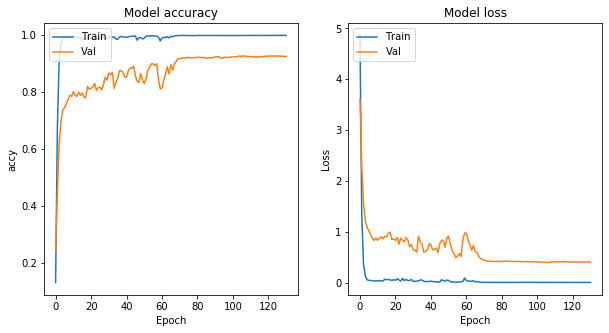

In [14]:
# plot training and validation iou_score values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training and validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()